# Harlowton (1KM) ProbGust Reliablity

Calculate the reliability of ProbGust, and previous guidance.

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()

## Define utility functions

### load_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [3]:
def load_forecast_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data['valid_time'] = data.reference_time + data.time_since_reference * hour
    data = data.set_index(['reference_time', 'valid_time']).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### convert_units
Convert units of columns in a DataFrame

In [4]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### filter_missing_data
Filter rows that are filled with NaNs, ignoring time fields by default

In [5]:
def filter_missing_data(data):
    return data.dropna(how='all')

### load_observations
Load time series from observation source, converting units and filtering fields.

In [6]:
def load_observations(filename, filter_fields=None):
    data = xr.open_dataset(filename).to_dataframe().set_index('time').sort_index()
    if filter_fields is not None:
        data = data.loc[:, filter_fields]
    return data

### replace_missing_gust_with_wind
Since that gusts for AWOS/ASOS are not reported unless the gusts is sufficiently higher than sustained wind, replace missing gust values with the sustained to compare to RTMA / NBM that always has a gust value.

In [7]:
def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
    index = np.isnan(data[wind_gust_field])
    data.loc[index, wind_gust_field] = data[wind_field][index]

### get_period_maximum
Find the maximum values when rounding the time fields to nearest time period

In [8]:
def get_period_maximum(data, period='1H'):
    return data.groupby(data.index.round(period)).max()

### convert_units
Convert units of columns in a DataFrame

In [9]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### time_match_dataset
Time-match dataset while prefixing the columns of each dataset

In [10]:
def time_match_dataset(left, right, left_prefix='obs', right_prefix='grid', left_time='time', right_time='valid_time'):
    left_data = left.copy(deep=True)
    left_data.columns = ['{0:s}_{1:s}'.format(x, left_prefix) for x in left_data.columns]
    right_data = right.copy(deep=True)
    right_data.columns = ['{0:s}_{1:s}'.format(x, right_prefix) for x in right_data.columns]
    return pd.merge(left_data, right_data, how='inner', left_on='{0:s}_{1:s}'.format(left_time, left_prefix), right_on='{0:s}_{1:s}'.format(right_time, right_prefix)).reset_index()

### filter_three_hourly
Filter NBM data to 3 hourly forecast

In [11]:
def filter_three_hourly(data, time_field='valid_time'):
    return data[data.index.get_level_values(time_field).hour % 3 == 0]

### generate_probability
Calculate the Z-Score given the bias-corrected NBM mean wind gust and standard deviation

In [12]:
def generate_prob_gust(data, threshold, unit='mph', tollerance = 0.6, mean='10_meter_wind_speed_of_gust_mean', standard_deviation='10_meter_wind_speed_of_gust_standard_deviation'):
    threshold = pint.Quantity(threshold - tollerance, units(unit)).to(units('m s**-1')).magnitude
    z_score = pd.Series((threshold - data[mean]) / data[standard_deviation], index=data.index)
    return pd.Series(np.round((100 * normal_distribution.sf(z_score))), index=data.index)


### standard_error_of_estimate
calculate the standard error from a slope and intercept

In [13]:
def standard_error_of_estimate(x, y, slope, intercept):
    x = np.array(x)
    y = np.array(y)
    error = np.inf
    if len(x) > 2:
        error = np.sqrt(np.sum(((slope * x + intercept) - y)**2) / (len(x) - 2))
    return error

### correction
Apply operational correction to the time-lagged NAM proability for 6S0

In [14]:
def correction(criteria, value):
    new_value = value
    if criteria == 50:
        if value < 5:
            new_value = 1
        elif (5 <= value) and (value < 10):
            new_value = 9
        elif (10 <= value) and (value < 20):
            new_value = 19
        elif (20 <= value) and (value < 30):
            new_value = 31
        elif (30 <= value) and (value < 40):
            new_value = 43
        elif (40 <= value) and (value < 50):
            new_value = 58
        else:
            new_value = 73
    elif criteria == 60:
        if value < 5:
            new_value = 0
        elif (5 <= value) and (value < 10):
            new_value = 1
        elif (10 <= value) and (value < 20):
            new_value = 2
        elif (20 <= value) and (value < 30):
            new_value = 6
        elif (30 <= value) and (value < 40):
            new_value = 10
        elif (40 <= value) and (value < 50):
            new_value = 15
        else:
            new_value = 26
    elif criteria == 70:
        if value < 5:
            new_value = 0
        elif (5 <= value) and (value < 10):
            new_value = 0
        elif (10 <= value) and (value < 20):
            new_value = 0
        elif (20 <= value) and (value < 30):
            new_value = 0
        elif (30 <= value) and (value < 40):
            new_value = 1
        elif (40 <= value) and (value < 50):
            new_value = 3
        else:
            new_value = 5
    return new_value

## Read Bias-Correction parameters

In [15]:
# regression = xr.open_dataset('../data/derived/6S0_regression.nc').to_dataframe()
regression = pd.read_json('../data/derived/regressions.json', orient='table')
regression

,slope,intercept,rvalue,pvalue,stderr
6S0,1.139874,2.580342,0.842540,0.000000e+00,0.015687
1KM,0.852204,5.806669,0.800694,1.319024e-211,0.020786


## Load Observation Data

In [16]:
obs =  load_observations('../data/observations/1KM.nc', 
                         filter_fields=['10_meter_wind_speed', '10_meter_wind_speed_of_gust', '10_meter_wind_from_direction'])
# convert_units(obs,{
#     '10_meter_wind_speed': ('m s**-1', 'knots'),
#     '10_meter_wind_speed_of_gust': ('m s**-1', 'knots')
# })
replace_missing_gust_with_wind(obs, '10_meter_wind_speed', '10_meter_wind_speed_of_gust')
obs = filter_missing_data(obs)
obs = get_period_maximum(obs, period='3H')
obs
# obs = get_period_maximum(filter_missing_data(replace_missing_gust_with_wind(load_observations('../data/observations/6S0.nc', from_units={'10_meter_wind_speed': 'm s**-1', '10_meter_wind_speed_of_gust': 'm s**-1'}, to_units={'10_meter_wind_speed': 'mph', '10_meter_wind_speed_of_gust': 'mph'}, filter_fields=['10_meter_wind_speed', '10_meter_wind_speed_of_gust']), '10_meter_wind_speed', '10_meter_wind_speed_of_gust')), period='3H')[['time', '10_meter_wind_speed_of_gust']]
# obs.columns = ['Valid Time (UTC)', 'Observed Gust (MPH)']
# obs

,10_meter_wind_speed,10_meter_wind_speed_of_gust,10_meter_wind_from_direction
time,,,
2020-05-18 00:00:00,0.000000,0.000000,0.0
2020-05-18 03:00:00,4.115556,4.115556,360.0
2020-05-18 06:00:00,3.086667,3.086667,350.0
2020-05-18 09:00:00,3.086667,3.086667,340.0
2020-05-18 12:00:00,3.086667,8.745556,310.0
...,...,...,...
2021-04-17 09:00:00,5.658889,5.658889,280.0
2021-04-17 12:00:00,5.144444,5.144444,290.0
2021-04-17 15:00:00,5.144444,5.144444,310.0


## Load NBM Forecast Data
calculate apply bias-correction and calculate ProbGust

In [17]:
nbm = load_forecast_grid('../data/nbm/NBM_1KM.nc', filter_fields=['10_meter_wind_speed_of_gust_mean', '10_meter_wind_speed_of_gust_standard_deviation'])

# convert_units(nbm,{
#     '10_meter_wind_speed_of_gust_mean': ('m s**-1', 'knots')
# })

nbm = filter_missing_data(nbm)
nbm['10_meter_wind_speed_of_gust_mean'] = regression.slope['1KM'] * nbm['10_meter_wind_speed_of_gust_mean'] + regression.intercept['1KM']
nbm_short = nbm[np.round((nbm.index.get_level_values('valid_time') - nbm.index.get_level_values('reference_time')).total_seconds()/3600.0) <= 36].copy(deep=True)
nbm_long = nbm[np.round((nbm.index.get_level_values('valid_time') - nbm.index.get_level_values('reference_time')).total_seconds()/3600.0) > 36].copy(deep=True)
nbm = filter_three_hourly(nbm)



smoothed_nbm = nbm.groupby(level='reference_time').apply(lambda s: s.rolling(window=3, min_periods=2, center=True).mean())

for threshold in [50, 58, 70]:
    nbm['ProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm, threshold)
    nbm['SmootehdNBMProbGust_{0:d}'.format(threshold)] = generate_prob_gust(smoothed_nbm, threshold)
    nbm_short['ShortProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm_short, threshold)
    nbm_long['LongProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm_long, threshold)
nbm[[col.replace('ProbGust', 'ProbGustSmoothed') for col in nbm.columns if col.find('ProbGust') > -1]] = nbm.groupby(level='reference_time').apply(lambda s: s.rolling(window=3, min_periods=2, center=True).mean())[[col for col in nbm.columns if col.find('ProbGust') > -1]]
nbm[[col.replace('ProbGust', 'ProbGustTL') for col in nbm.columns if col.find('ProbGust') > -1]] = nbm.reset_index().set_index(['valid_time', 'reference_time']).sort_index(level=['valid_time', 'reference_time']).groupby(level='valid_time').apply(lambda s: s.rolling(window=12, min_periods=1).mean()).reset_index().set_index(['reference_time', 'valid_time']).sort_index(level=['reference_time', 'valid_time'])[[col for col in nbm.columns if col.find('ProbGust') > -1]]
nbm = nbm[[col for col in nbm.columns if col.find('ProbGust') > -1]]

nbm_short[[col.replace('ProbGust', 'ProbGustSmoothed') for col in nbm_short.columns if col.find('ProbGust') > -1]] = nbm_short.groupby(level='reference_time').apply(lambda s: s.rolling(window=7, min_periods=4, center=True).mean())[[col for col in nbm_short.columns if col.find('ProbGust') > -1]]
nbm_short = nbm_short[[col for col in nbm_short.columns if col.find('ProbGust') > -1]]
nbm_long[[col.replace('ProbGust', 'ProbGustSmoothed') for col in nbm_long.columns if col.find('ProbGust') > -1]] = nbm_long.groupby(level='reference_time').apply(lambda s: s.rolling(window=3, min_periods=2, center=True).mean())[[col for col in nbm_long.columns if col.find('ProbGust') > -1]]
nbm_long = nbm_long[[col for col in nbm_long.columns if col.find('ProbGust') > -1]]

nbm

ProbGust_50  SmootehdNBMProbGust_50  \
reference_time      valid_time                                                 
2020-10-01 09:00:00 2020-10-01 12:00:00          0.0                     0.0   
                    2020-10-01 15:00:00          0.0                     0.0   
                    2020-10-01 18:00:00          0.0                     0.0   
                    2020-10-01 21:00:00          0.0                     0.0   
                    2020-10-02 00:00:00          0.0                     0.0   
...                                              ...                     ...   
2021-03-27 09:00:00 2021-04-02 21:00:00          0.0                     0.0   
                    2021-04-03 00:00:00          0.0                     0.0   
                    2021-04-03 03:00:00          0.0                     0.0   
                    2021-04-03 06:00:00          0.0                     0.0   
                    2021-04-03 09:00:00          0.0                     0.0   

                                         ProbGust_58  SmootehdNBMProbGust_58  \
reference_time      valid_time                                                 
2020-10-01 09:00:00 2020-10-01 12:00:00          0.0                     0.0   
                    2020-10-01 15:00:00          0.0                     0.0   
                    2020-10-01 18:00:00          0.0                     0.0   
                    2020-10-01 21:00:00          0.0                     0.0   
                    2020-10-02 00:00:00          0.0                     0.0   
...                                              ...                     ...   
2021-03-27 09:00:00 2021-04-02 21:00:00          0.0                     0.0   
                    2021-04-03 00:00:00          0.0                     0.0   
                    2021-04-03 03:00:00          0.0                     0.0   
                    2021-04-03 06:00:00          0.0                     0.0   
                    2021-04-03 09:00:00          0.0                     0.0   

                                         ProbGust_70  SmootehdNBMProbGust_70  \
reference_time      valid_time                                                 
2020-10-01 09:00:00 2020-10-01 12:00:00          0.0                     0.0   
                    2020-10-01 15:00:00          0.0                     0.0   
                    2020-10-01 18:00:00          0.0                     0.0   
                    2020-10-01 21:00:00          0.0                     0.0   
                    2020-10-02 00:00:00          0.0                     0.0   
...                                              ...                     ...   
2021-03-27 09:00:00 2021-04-02 21:00:00          0.0                     0.0   
                    2021-04-03 00:00:00          0.0                     0.0   
                    2021-04-03 03:00:00          0.0                     0.0   
                    2021-04-03 06:00:00          0.0                     0.0   
                    2021-04-03 09:00:00          0.0                     0.0   

                                         ProbGustSmoothed_50  \
reference_time      valid_time                                 
2020-10-01 09:00:00 2020-10-01 12:00:00                  0.0   
                    2020-10-01 15:00:00                  0.0   
                    2020-10-01 18:00:00                  0.0   
                    2020-10-01 21:00:00                  0.0   
                    2020-10-02 00:00:00                  0.0   
...                                                      ...   
2021-03-27 09:00:00 2021-04-02 21:00:00                  0.0   
                    2021-04-03 00:00:00                  0.0   
                    2021-04-03 03:00:00                  0.0   
                    2021-04-03 06:00:00                  0.0   
                    2021-04-03 09:00:00                  0.0   

                                         SmootehdNBMProbGustSmoothed_50  \
reference_

## Load Operation Probability Guidance

In [18]:
previous = xr.open_dataset('../data/database/UMHMmodel.nc').to_dataframe()
previous = previous.fillna(0)
previous = previous[(previous.model == 'GFS')][['run', 'valid', 'Dsfc', 'Ssfc']].sort_values(['valid', 'run']).reset_index(drop=True)
previous['OriginalSubwarningProb_50'] = 0.0624 * np.power(previous.Ssfc, 2.0) + 1.4206 * previous.Ssfc - 10.351
previous.loc[(previous.Dsfc < 240) | (previous.Dsfc > 315), 'OriginalSubwarningProb_50'] = 0
previous.loc[previous.OriginalSubwarningProb_50 < 0, 'OriginalSubwarningProb_50'] = 0
previous.loc[previous.OriginalSubwarningProb_50 > 100, 'OriginalSubwarningProb_50'] = 100
previous = previous[['run', 'valid', 'OriginalSubwarningProb_50']]
previous.columns = ['reference_time', 'valid_time', 'OriginalSubwarningProb_50']
previous = previous.set_index(['reference_time', 'valid_time'])
previous['TimeLaggedSubwarningProb_50'] = previous.groupby(level='reference_time').apply(lambda s: s.rolling(window=12, min_periods=1).mean())['OriginalSubwarningProb_50']

for threshold in [50, 58, 70]:
    previous['OperationalProb_{0:d}'.format(threshold)] = previous['TimeLaggedSubwarningProb_50'].apply(lambda a: correction(threshold, a))

previous

OriginalSubwarningProb_50  \
reference_time      valid_time                                       
2013-12-26 12:00:00 2013-12-26 12:00:00                      0.000   
                    2013-12-26 18:00:00                      0.000   
2013-12-26 18:00:00 2013-12-26 18:00:00                      0.000   
2013-12-26 12:00:00 2013-12-27 00:00:00                      0.000   
2013-12-26 18:00:00 2013-12-27 00:00:00                      0.000   
...                                                            ...   
2021-03-22 06:00:00 2021-04-01 00:00:00                     10.095   
2021-03-22 12:00:00 2021-04-01 00:00:00                      0.000   
2021-03-22 06:00:00 2021-04-01 06:00:00                      0.000   
2021-03-22 12:00:00 2021-04-01 06:00:00                      0.000   
                    2021-04-01 12:00:00                      0.000   

                                         TimeLaggedSubwarningProb_50  \
reference_time      valid_time                                         
2013-12-26 12:00:00 2013-12-26 12:00:00                     0.000000   
                    2013-12-26 18:00:00                     0.000000   
2013-12-26 18:00:00 2013-12-26 18:00:00                     0.000000   
2013-12-26 12:00:00 2013-12-27 00:00:00                     0.000000   
2013-12-26 18:00:00 2013-12-27 00:00:00                     0.000000   
...                                                              ...   
2021-03-22 06:00:00 2021-04-01 00:00:00                    11.357567   
2021-03-22 12:00:00 2021-04-01 00:00:00                    22.039217   
2021-03-22 06:00:00 2021-04-01 06:00:00                    11.357567   
2021-03-22 12:00:00 2021-04-01 06:00:00                    15.510267   
                    2021-04-01 12:00:00                    13.147517   

                                         OperationalProb_50  \
reference_time      valid_time                                
2013-12-26 12:00:00 2013-12-26 12:00:00                   1   
                    2013-12-26 18:00:00                   1   
2013-12-26 18:00:00 2013-12-26 18:00:00                   1   
2013-12-26 12:00:00 2013-12-27 00:00:00                   1   
2013-12-26 18:00:00 2013-12-27 00:00:00                   1   
...                                                     ...   
2021-03-22 06:00:00 2021-04-01 00:00:00                  19   
2021-03-22 12:00:00 2021-04-01 00:00:00                  31   
2021-03-22 06:00:00 2021-04-01 06:00:00                  19   
2021-03-22 12:00:00 2021-04-01 06:00:00                  19   
                    2021-04-01 12:00:00                  19   

                                         OperationalProb_58  \
reference_time      valid_time                                
2013-12-26 12:00:00 2013-12-26 12:00:00            0.000000   
                    2013-12-26 18:00:00            0.000000   
2013-12-26 18:00:00 2013-12-26 18:00:00            0.000000   
2013-12-26 12:00:00 2013-12-27 00:00:00            0.000000   
2013-12-26 18:00:00 2013-12-27 00:00:00            0.000000   
...                                                     ...   
2021-03-22 06:00:00 2021-04-01 00:00:00           11.357567   
2021-03-22 12:00:00 2021-04-01 00:00:00           22.039217   
2021-03-22 06:00:00 2021-04-01 06:00:00           11.357567   
2021-03-22 12:00:00 2021-04-01 06:00:00           15.510267   
                    2021-04-01 12:00:00           13.147517   

                                         OperationalProb_70  
reference_time      valid_time                               
2013-12-26 12:00:00 2013-12-26 12:00:00                   0  
                    2013-12-26 18:00:00                   0  
2013-12-26 18:00:00 2013-12-26 18:00:00                   0  
2013-12-26 12:00:00 2013-12-27 00:00:00                   0  
2013-12-26 18:00:00 2013-12-27 00:00:00                   0  
...                                                     ...  
2021-03-22 06:00:00 2021-04-01 00:00:00                  

In [19]:

# pd.merge(left=nbm, right=obs[['10_meter_wind_speed_of_gust']].rename_axis('valid_time'), right_index=True, left_index=True, how='inner')

## Time-match Observations, NBM, and Operational Guidance

In [20]:
# data = pd.merge(left=nbm, right=previous, left_on=['NBM Cycle', 'Valid Time (UTC)'], right_on=['NAM Cycle', 'Valid Time (UTC)'], how='outer')[['NBM Cycle', 'Valid Time (UTC)'] + ['ProbGust{0:d}'.format(t) for t in [50, 58, 70]] + ['ProbGust{0:d}_MovingAvg'.format(t) for t in [50, 58, 70]] + ['WrnProb', 'WrnProbTL'] + ['Prob{0:d}TL'.format(t) for t in [50, 60, 70]]]
# data.columns = ['NBM Cycle', 'Valid Time (UTC)'] + ['ProbGust{0:d}'.format(t) for t in [50, 58, 70]] + ['ProbGust{0:d}_MovingAvg'.format(t) for t in [50, 58, 70]] + ['Original WrnProb', 'Original WrnProb Time-lagged'] + ['Oper. WrnProb{0:d} Time-lagged'.format(t) for t in [50, 60, 70]]

# for col in [x for x in data.columns if x not in ['Valid Time (UTC)', 'NBM Cycle'] + ['Prob{0:d}TL'.format(t) for t in [50, 60, 70]]]:
#     data[col] = np.round(data[col] / 5) * 5

# data = pd.merge(obs, data[[x for x in data.columns if x != 'NBM Cycle']].melt(id_vars=['Valid Time (UTC)'], var_name='Method', value_name='Probability'), how='inner', left_on='Valid Time (UTC)', right_on='Valid Time (UTC)').dropna()
# verify_citeria = dict(zip(['ProbGust50', 'ProbGust58', 'ProbGust70', 'ProbGust50_MovingAvg','ProbGust58_MovingAvg', 'ProbGust70_MovingAvg', 'Original WrnProb','Original WrnProb Time-lagged', 'Oper. WrnProb50 Time-lagged','Oper. WrnProb60 Time-lagged', 'Oper. WrnProb70 Time-lagged'],
#                           [ 50,           58,           70,           50,                    58,                     70,                     58,                58,                             50,                           58,                            70]))
# data['Criteria'] = data.Method.apply(verify_citeria.get)
# data['Hit'] = data.apply(lambda a: a['Observed Gust (MPH)'] >= a.Criteria, axis=1)
# reliablity = data[['Method', 'Probability', 'Hit']].groupby(['Method','Probability']).Hit.apply(lambda a: (a.sum()/a.count() * 10) * 10).reset_index()
# reliablity
data = pd.merge(left=pd.concat([previous.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),
                                     nbm.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),
                               nbm_short.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),
                                nbm_long.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value')]).set_index(['reference_time', 'valid_time']).sort_index(), 
                right=obs[['10_meter_wind_speed_of_gust']].rename_axis('valid_time'), right_index=True, left_index=True, how='inner')
data.Value = (data.Value / 5).round() * 5

data['Criteria'] = pint.Quantity(data.Dataset.str.split('_', expand=True)[[1]].astype('uint8'), units('mph')).to(units('m s**-1')).magnitude
data['Hit'] = data.apply(lambda row: row['10_meter_wind_speed_of_gust'] >= row['Criteria'], axis=1)
reliability = data[['Dataset', 'Value', 'Hit']].groupby(['Dataset', 'Value']).Hit.apply(lambda a: (a.sum()/a.count() * 100)).reset_index()
reliability

,Dataset,Value,Hit
0,LongProbGustSmoothed_50,0.0,1.598530
1,LongProbGustSmoothed_50,5.0,10.757946
2,LongProbGustSmoothed_50,10.0,14.000000
3,LongProbGustSmoothed_50,15.0,16.778523
4,LongProbGustSmoothed_50,20.0,24.468085
...,...,...,...
534,TimeLaggedSubwarningProb_50,80.0,22.222222
535,TimeLaggedSubwarningProb_50,85.0,40.000000
536,TimeLaggedSubwarningProb_50,90.0,63.636364
537,TimeLaggedSubwarningProb_50,95.0,75.000000


## Generate Reliability Regressions

In [21]:
# reliability_regressions = None
# for method in reliablity.Method.unique():
#     method_data = reliablity[reliablity.Method == method]
#     method_regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'stderr_perfect'], list(stats.linregress(method_data.Probability, method_data.Hit)) + [0])), index=[method])
#     method_regression.loc[method, 'stderr'] = standard_error_of_estimate(method_data.Probability, method_data.Hit, method_regression['slope'][method], method_regression['intercept'][method])
#     method_regression.loc[method, 'stderr_perfect'] = standard_error_of_estimate(method_data.Probability, method_data.Hit, 1.0, 0.0)
#     if reliability_regressions is None:
#         reliability_regressions = method_regression
#     else:
#         reliability_regressions = pd.concat([reliability_regressions, method_regression])
# reliability_regressions
reliability_regressions = None
for dataset in reliability.Dataset.unique():
    dataset_data = reliability[reliability.Dataset == dataset]
    dataset_regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'stderr_perfect'], list(stats.linregress(dataset_data.Value, dataset_data.Hit)) + [0])), index=[dataset])
    dataset_regression.loc[dataset, 'stderr'] = standard_error_of_estimate(dataset_data.Value, dataset_data.Hit, dataset_regression['slope'][dataset], dataset_regression['intercept'][dataset])
    dataset_regression.loc[dataset, 'stderr_perfect'] = standard_error_of_estimate(dataset_data.Value, dataset_data.Hit, 1.0, 0.0)
    if reliability_regressions is None:
        reliability_regressions = dataset_regression
    else:
        reliability_regressions = pd.concat([reliability_regressions, dataset_regression])
reliability_regressions

,slope,intercept,rvalue,pvalue,stderr,stderr_perfect
LongProbGustSmoothed_50,0.725318,12.140221,0.883855,2.379222e-07,11.665864,14.376832
LongProbGustSmoothed_58,0.589881,19.288618,0.494976,6.066649e-02,24.028697,26.382590
LongProbGustSmoothed_70,0.047959,8.335983,0.030902,9.690984e-01,12.263648,14.488107
LongProbGust_50,0.625685,12.200481,0.838278,2.090694e-06,12.953777,18.885769
LongProbGust_58,0.999841,6.415543,0.830481,1.984871e-05,18.452296,19.664534
LongProbGust_70,0.025684,9.927784,0.029448,9.558409e-01,10.528053,16.228127
OperationalProb_50,0.360062,-1.830245,0.987253,3.499211e-05,1.726113,34.002883
OperationalProb_58,0.561583,-11.573449,0.721150,2.252403e-04,17.172027,41.588187
OperationalProb_70,0.311724,0.143991,1.000000,0.000000e+00,inf,inf
OriginalSubwarningProb_50,0.572739,-7.016098,0.946754,8.441317e-11,6.199493,33.369724


## Generate Reliability Plots

['OriginalSubwarningProb', 'TimeLaggedSubwarningProb', 'OperationalProb', 'ProbGust', 'ProbGustSmoothed', 'SmootehdNBMProbGust', 'SmootehdNBMProbGustSmoothed', 'ProbGustTL', 'ProbGustTLSmoothed', 'SmootehdNBMProbGustTL', 'SmootehdNBMProbGustTLSmoothed', 'ShortProbGust', 'ShortProbGustSmoothed', 'LongProbGust', 'LongProbGustSmoothed']


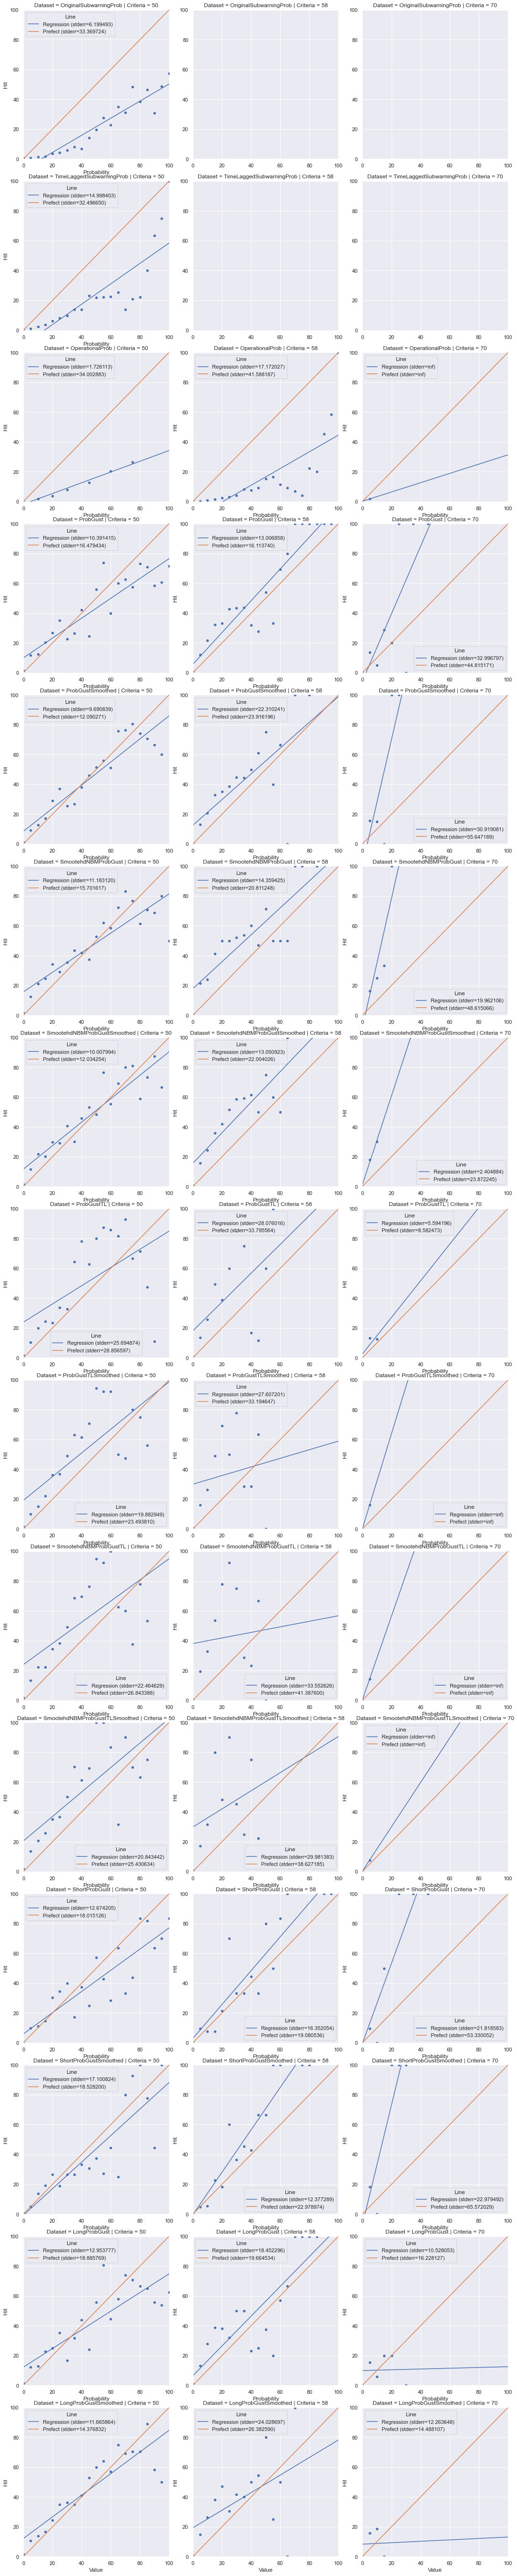

In [24]:
plot_data = reliability.copy(deep=True)
plot_data['Criteria'] = plot_data.Dataset.str.split('_', expand=True)[[1]]
plot_data.Dataset = plot_data.Dataset.str.split('_', expand=True)[[0]]

dataset_order = ['OriginalSubwarningProb', 'TimeLaggedSubwarningProb', 'OperationalProb', 'ProbGust', 'ProbGustSmoothed', 'SmootehdNBMProbGust', 'SmootehdNBMProbGustSmoothed', 'ProbGustTL', 'ProbGustTLSmoothed', 'SmootehdNBMProbGustTL', 'SmootehdNBMProbGustTLSmoothed', 'ShortProbGust', 'ShortProbGustSmoothed', 'LongProbGust', 'LongProbGustSmoothed']
dataset_order += [col for col in plot_data.columns if col not in dataset_order and col not in ['Dataset', 'Value', 'Hit', 'Criteria']]
print(dataset_order)
g = sns.relplot(data=plot_data, x='Value', y='Hit', col='Criteria', row='Dataset', row_order=dataset_order, facet_kws=dict(ylim=(0,100), xlim=(0,100), sharex=False, sharey=False))
for plot_vars, ax in g.axes_dict.items():
    method = '_'.join(plot_vars)
    if method in reliability_regressions.index:
        curve_data = pd.DataFrame({'Probability': np.array([0,100]),
               'Regression (stderr={0:f})'.format(reliability_regressions['stderr'][method]): reliability_regressions['slope'][method] * np.array([0,100]) + reliability_regressions['intercept'][method],
               'Prefect (stderr={0:f})'.format(reliability_regressions['stderr_perfect'][method]): np.array([0,100])}).melt(id_vars=['Probability'], var_name='Line', value_name='Hit')
        sns.lineplot(data=curve_data, x='Probability', y='Hit', hue='Line', ax=ax)
g.savefig('output/reliablity.png')

In [23]:
obs[obs['Observed Gust (MPH)'] >= 50].count()

KeyError: 'Observed Gust (MPH)'